In [135]:
import datetime

from tqdm import keras

print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-09-08 17:42:36.344294


In [136]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print(e)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)


Num GPUs Available:  1
2.10.0


In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import layers

In [138]:
x = [12, 534, 32, 13, -123, 23, -11, 99]
y = [1, 0, 1, 2, 1, 0, 2, 2]

x2 = [[12, 534],[ 32, 13],[ -123, 23],[ -11, 99]]
y2 = [1, 0, 1, 2]


In [139]:
dataset = tf.data.Dataset.from_tensor_slices((x,y))
dataset_2 = tf.data.Dataset.from_tensor_slices((x2,y2))

In [140]:
for value,label in dataset.as_numpy_iterator():
    print(value,label)

12 1
534 0
32 1
13 2
-123 1
23 0
-11 2
99 2


In [141]:
dataset = dataset.filter(lambda x,y: x > 0)

In [142]:
for value,label in dataset.as_numpy_iterator():
    print(value,label)

12 1
534 0
32 1
13 2
23 0
99 2


In [143]:
for value,label in dataset_2.as_numpy_iterator():
    print(value,label)

[ 12 534] 1
[32 13] 0
[-123   23] 1
[-11  99] 2


In [144]:
file_path= '../pizza_steak'
train_path = file_path + '/train/'
test_path = file_path + '/test/'

In [145]:
import os
for dirpath,dirnames, filenames in os.walk(file_path):
    print(f'Directory {dirpath+"/"} has {len(dirnames)} directories and {len(filenames)} files')

Directory ../pizza_steak/ has 2 directories and 0 files
Directory ../pizza_steak\test/ has 2 directories and 0 files
Directory ../pizza_steak\test\pizza/ has 0 directories and 250 files
Directory ../pizza_steak\test\steak/ has 0 directories and 250 files
Directory ../pizza_steak\train/ has 2 directories and 0 files
Directory ../pizza_steak\train\pizza/ has 0 directories and 750 files
Directory ../pizza_steak\train\steak/ has 0 directories and 750 files


In [146]:
class_names=['Pizza','Steak']

In [147]:
def extract_files(file_path,x_dict):
    for dirpath,dirnames, filenames in os.walk(file_path):
        for file in os.listdir(dirpath):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                x_dict['images'].append(dirpath + '/'+  file)
                x_dict['labels'].append(dirpath.split('/')[-1])

In [148]:
import copy

train_dict = {
    'images': [],
    'labels': []
}
test_dict = copy.deepcopy(train_dict)

extract_files(train_path,train_dict)
extract_files(test_path,test_dict)

In [149]:
print(f'train data : {len(train_dict["labels"])} \ntest data : { len(test_dict["labels"])}')

train data : 1500 
test data : 500


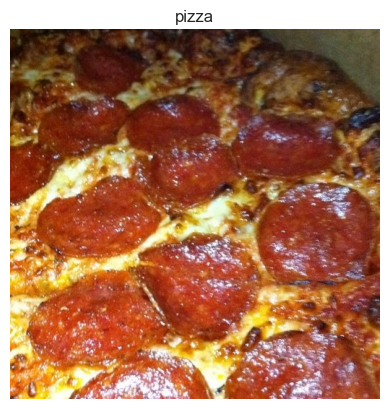

In [150]:
import random
rand_nb = random.randint(0,len(train_dict['images'])-1)
image = train_dict['images'][rand_nb]
label = train_dict['labels'][rand_nb]

img = plt.imread(image)

plt.imshow(img)
plt.title(f'{label}')
plt.axis('off');

In [151]:
IMG_SIZE = 224

In [152]:
def process_dataset(x, y):
    label = y
    if label == 'pizza':
        integer_label = 0
    else:
        integer_label = 1

    image = tf.io.read_file(x)
    image = tf.image.decode_jpeg(image, channels=3) # needed to specify channels
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32)  # Cast to float32 for normalization
    return image, integer_label

def scale(image, label):
    return image / 255, label

In [153]:
train_ds = tf.data.Dataset.from_tensor_slices((train_dict['images'], train_dict['labels']))

train_ds = train_ds.map(process_dataset).shuffle(1000).map(scale).batch(batch_size=32).cache().prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_dict['images'], test_dict['labels']))
test_ds = test_ds.map(process_dataset).shuffle(1000).map(scale).batch(batch_size=32).cache().prefetch(tf.data.AUTOTUNE)

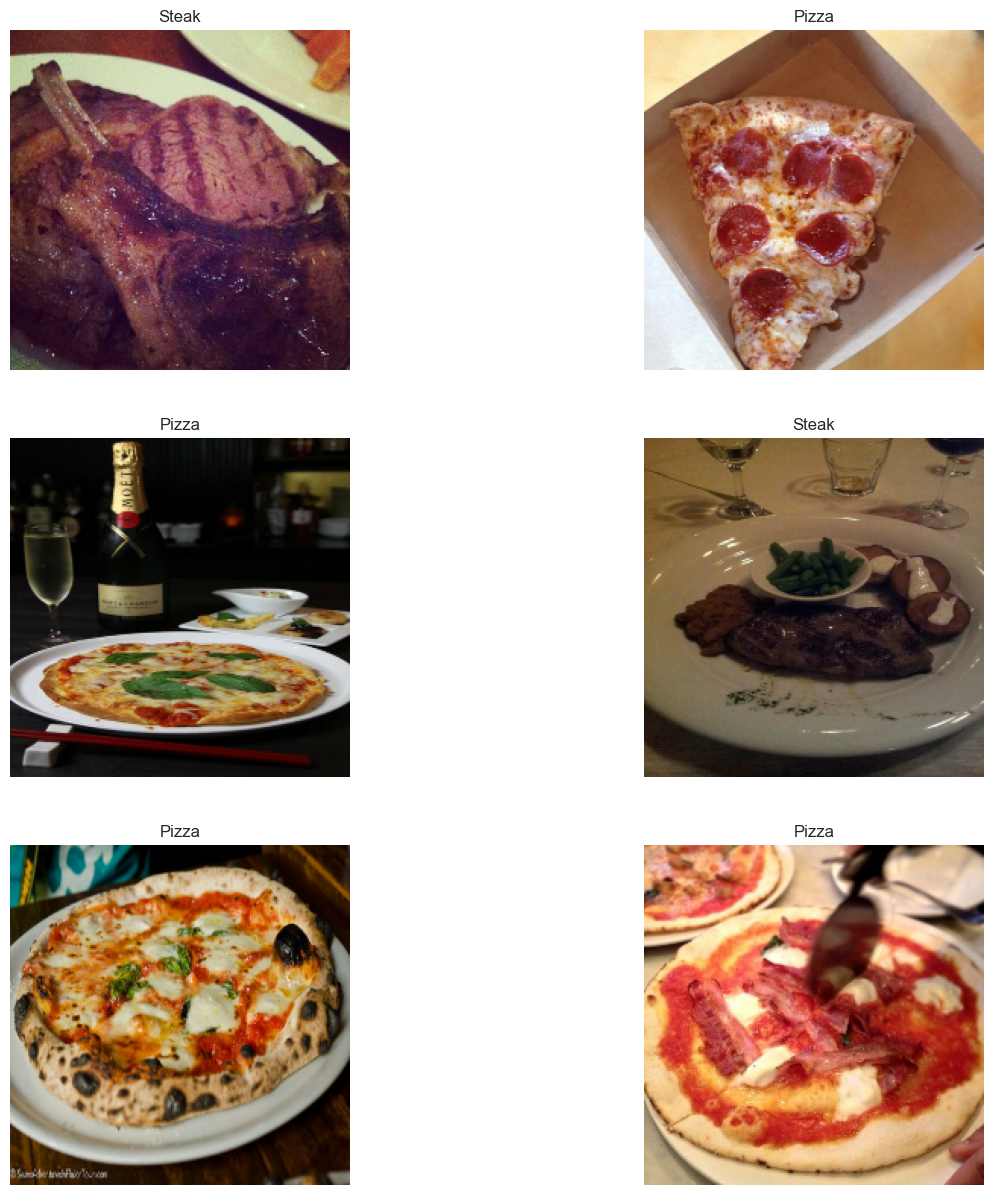

In [154]:
for batch_images, batch_labels in train_ds.take(1):
    plt.figure(figsize=(15, 15))
    for i in range(6):
        plt.subplot(3, 2, i + 1)
        plt.imshow(batch_images[i])
        plt.title(class_names[batch_labels[i]])
        plt.axis('off')

In [155]:
from keras import layers

In [156]:
# CROP_SIZE = 180
layer_augmentation = tf.keras.Sequential([
    # layers.RandomCrop(CROP_SIZE,CROP_SIZE), ## gives a graph error execution
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
])

In [157]:
model = tf.keras.models.Sequential([
    layer_augmentation,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(filters=32, kernel_size=(5,2), activation='relu'),
    layers.MaxPooling2D(pool_size=(3)),
    layers.Conv2D(filters=64, kernel_size=(7,1), activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.UpSampling2D(size=(3, 3)),  # This will increase spatial dimensions by a factor of 3
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),  # To maintain the increased size
    layers.MaxPooling2D(pool_size=(3)),
    layers.Flatten(),
    layers.Dense(units=1, activation='sigmoid')
])



In [158]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.keras.losses.binary_crossentropy,
               metrics=['accuracy'])

In [159]:
with tf.device('/GPU:0'):  # Use the first GPU

    history = model.fit(train_ds,
                          epochs=10,
                        validation_data=test_ds
                          )
    keys_to_delete = ['loss', 'val_loss'] 
    hist = pd.DataFrame(history.history)
    loss_hist = hist[keys_to_delete]
    hist.drop(keys_to_delete, axis=1, inplace=True)

    # for key in keys_to_delete:
    #     if key in history.history:
    #         del history.history[key]

Epoch 1/10
47/47 [==============================] - 31s 153ms/step - loss: 0.7001 - accuracy: 0.6033 - val_loss: 0.5046 - val_accuracy: 0.7620
Epoch 2/10
47/47 [==============================] - 7s 143ms/step - loss: 0.5047 - accuracy: 0.7653 - val_loss: 0.4209 - val_accuracy: 0.8160
Epoch 3/10
47/47 [==============================] - 7s 141ms/step - loss: 0.4737 - accuracy: 0.7860 - val_loss: 0.3851 - val_accuracy: 0.8400
Epoch 4/10
47/47 [==============================] - 7s 142ms/step - loss: 0.4648 - accuracy: 0.8007 - val_loss: 0.3665 - val_accuracy: 0.8420
Epoch 5/10
47/47 [==============================] - 7s 142ms/step - loss: 0.4612 - accuracy: 0.7980 - val_loss: 0.4074 - val_accuracy: 0.8300
Epoch 6/10
47/47 [==============================] - 7s 143ms/step - loss: 0.4476 - accuracy: 0.7987 - val_loss: 0.3533 - val_accuracy: 0.8560
Epoch 7/10
47/47 [==============================] - 7s 144ms/step - loss: 0.4231 - accuracy: 0.8060 - val_loss: 0.3435 - val_accuracy: 0.8600
Epoch

In [160]:
hist

,accuracy,val_accuracy
0,0.603333,0.762
1,0.765333,0.816
2,0.786000,0.840
3,0.800667,0.842
4,0.798000,0.830
5,0.798667,0.856
6,0.806000,0.860
7,0.820667,0.830
8,0.823333,0.858
9,0.834667,0.836


<Axes: >

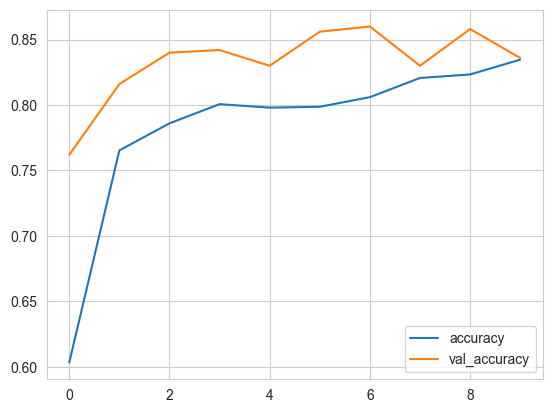

In [161]:
hist.plot()

<Axes: >

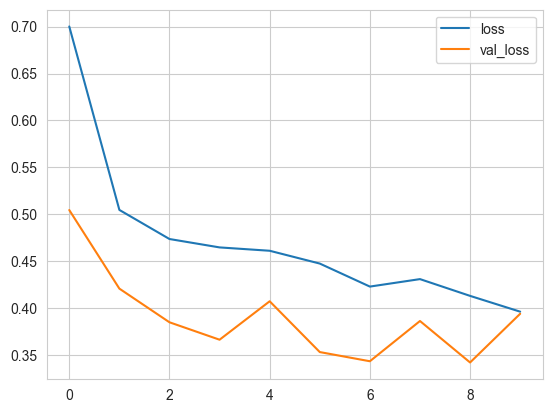

In [162]:
loss_hist.plot()